Experimentation and uplift testing

In [ ]:
# 1. Import all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# 1. Load the dataset
data = pd.read_csv("/content/QVI_data.csv")

# Convert DATE to datetime
data['DATE'] = pd.to_datetime(data['DATE'])
print(data.head())

# Create "Month" column
data['MONTH'] = data['DATE'].dt.to_period('M').dt.to_timestamp()

   LYLTY_CARD_NBR       DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000 2018-10-17          1       1         5   
1            1002 2018-09-16          1       2        58   
2            1003 2019-03-07          1       3        52   
3            1003 2019-03-08          1       4       106   
4            1004 2018-11-02          1       5        96   

                                PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0  Natural Chip        Compny SeaSalt175g         2        6.0        175   
1   Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7        150   
2   Grain Waves Sour    Cream&Chives 210G         1        3.6        210   
3  Natural ChipCo      Hony Soy Chckn175g         1        3.0        175   
4          WW Original Stacked Chips 160g         1        1.9        160   

        BRAND              LIFESTAGE PREMIUM_CUSTOMER  
0     NATURAL  YOUNG SINGLES/COUPLES          Premium  
1         RRD  YOUNG SINGLES/COUPLES       Mainstream  
2 

In [ ]:
# 3. Monthly summary per store

monthly = data.groupby(['STORE_NBR','MONTH']).agg(
    TOTAL_SALES = ('TOT_SALES','sum'),
    N_CUSTOMERS = ('LYLTY_CARD_NBR','nunique'),
    N_TXNS = ('TXN_ID','nunique')
).reset_index()

# Extra metric: transactions per customer
monthly['TXNS_PER_CUSTOMER'] = monthly['N_TXNS'] / monthly['N_CUSTOMERS']

In [ ]:
# 4. Trial and control store selection
trial_stores = [77, 86, 88]

# Trial period = last 3 months
all_months = sorted(monthly['MONTH'].unique())
trial_months = all_months[-3:]
pre_months = all_months[:-3]

print("Trial months:", trial_months)

# Helper: get monthly sales
def get_sales(store, months):
    temp = monthly[(monthly['STORE_NBR']==store) & (monthly['MONTH'].isin(months))]
    return temp.sort_values('MONTH')['TOTAL_SALES'].values

Trial months: [Timestamp('2019-04-01 00:00:00'), Timestamp('2019-05-01 00:00:00'), Timestamp('2019-06-01 00:00:00')]


In [ ]:
# Find control store by correlation
def find_control(trial_store):
    trial_sales = get_sales(trial_store, pre_months)
    best_store, best_corr = None, -1
    for store in monthly['STORE_NBR'].unique():
        if store == trial_store:
            continue
        sales = get_sales(store, pre_months)
        if len(sales) == len(trial_sales):
            corr = np.corrcoef(trial_sales, sales)[0,1]
            if corr > best_corr:
                best_corr, best_store = corr, store
    return best_store, best_corr

In [ ]:
# 5. Comparisons
for t in trial_stores:
    ctrl, corr = find_control(t)
    print(f"\nTrial store {t} -> Control store {ctrl} (corr={corr:.2f})")

    # Sales series
    trial_series = monthly[monthly['STORE_NBR']==t].sort_values('MONTH')
    ctrl_series = monthly[monthly['STORE_NBR']==ctrl].sort_values('MONTH')

    # Print trial vs control sales in trial period
    trial_sales = trial_series[trial_series['MONTH'].isin(trial_months)]['TOTAL_SALES'].sum()
    ctrl_sales = ctrl_series[ctrl_series['MONTH'].isin(trial_months)]['TOTAL_SALES'].sum()
    print(f" Trial sales: {trial_sales:.0f}, Control sales: {ctrl_sales:.0f}, Difference: {trial_sales-ctrl_sales:.0f}")



Trial store 77 -> Control store 17 (corr=0.86)
 Trial sales: 828, Control sales: 1022, Difference: -194

Trial store 86 -> Control store 109 (corr=0.83)
 Trial sales: 2576, Control sales: 2263, Difference: 312

Trial store 88 -> Control store 159 (corr=0.92)
 Trial sales: 4102, Control sales: 78, Difference: 4024


In [ ]:
# 6. Visualization

def plot_trial_vs_control(trial, control, metric, ylabel):
    trial_series = monthly[monthly['STORE_NBR']==trial].sort_values('MONTH')
    ctrl_series = monthly[monthly['STORE_NBR']==control].sort_values('MONTH')

    plt.figure(figsize=(8,4))
    plt.plot(trial_series['MONTH'], trial_series[metric], marker='o', label=f"Trial {trial}")
    plt.plot(ctrl_series['MONTH'], ctrl_series[metric], marker='s', label=f"Control {control}")

    # highlight trial period
    plt.axvspan(trial_months[0], trial_months[-1], color='gray', alpha=0.2, label="Trial period")

    plt.title(f"{metric} - Store {trial} vs Control {control}")
    plt.xlabel("Month")
    plt.ylabel(ylabel)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




Trial store 77 -> Control store 17 (corr=0.86)


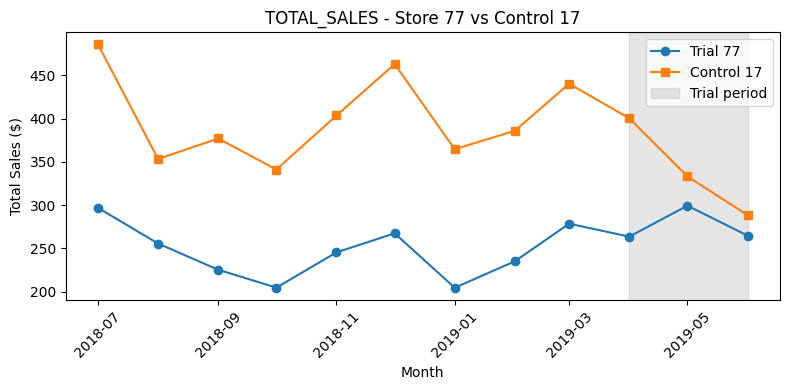

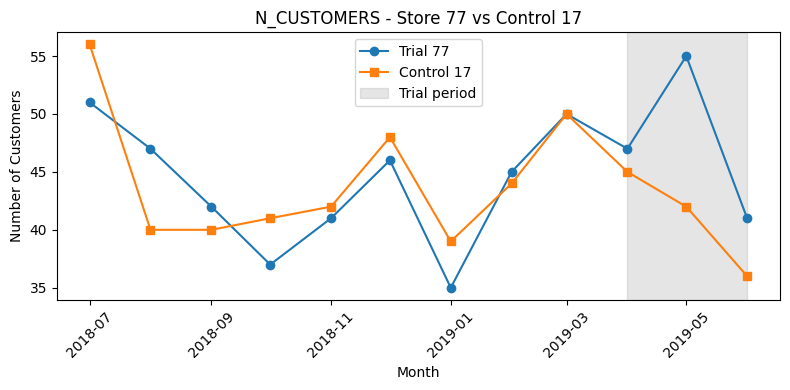

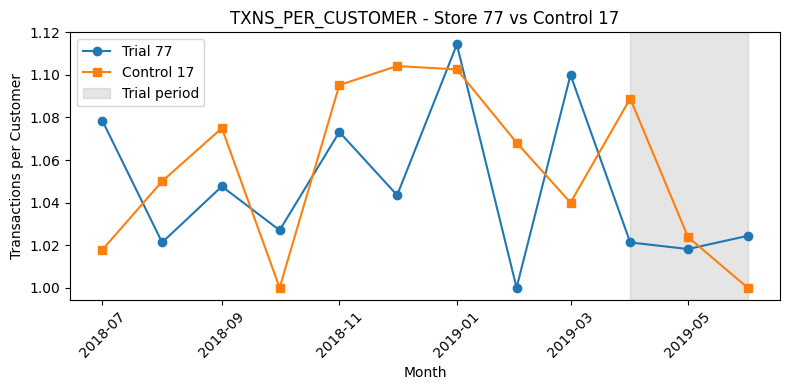


Trial store 86 -> Control store 109 (corr=0.83)


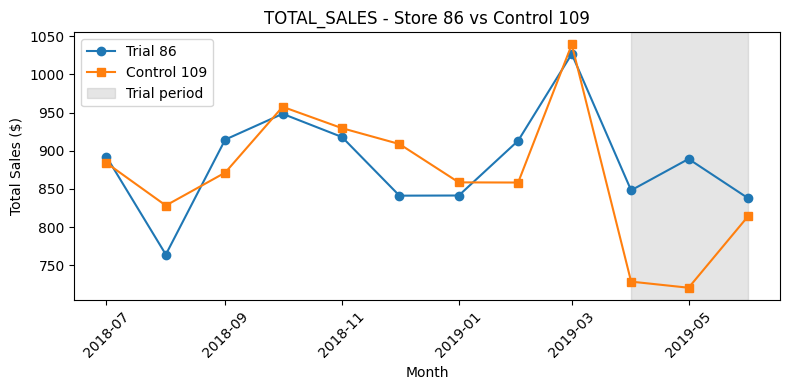

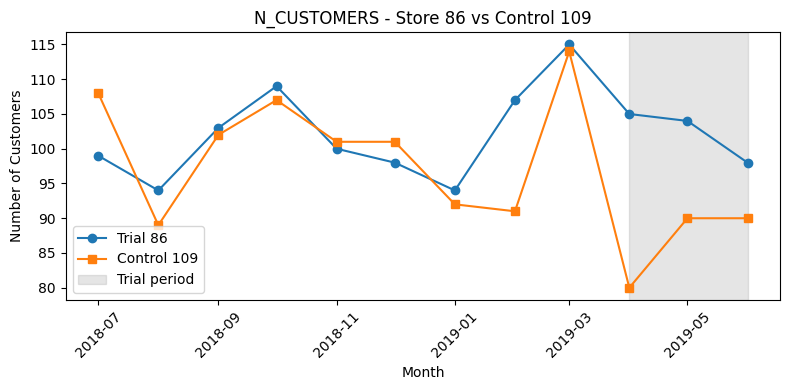

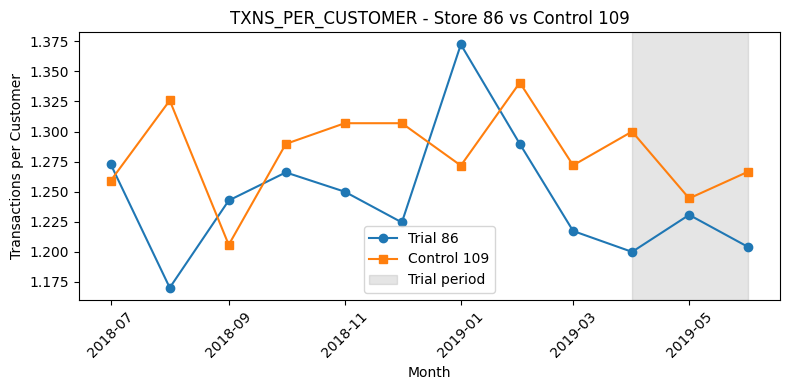


Trial store 88 -> Control store 159 (corr=0.92)


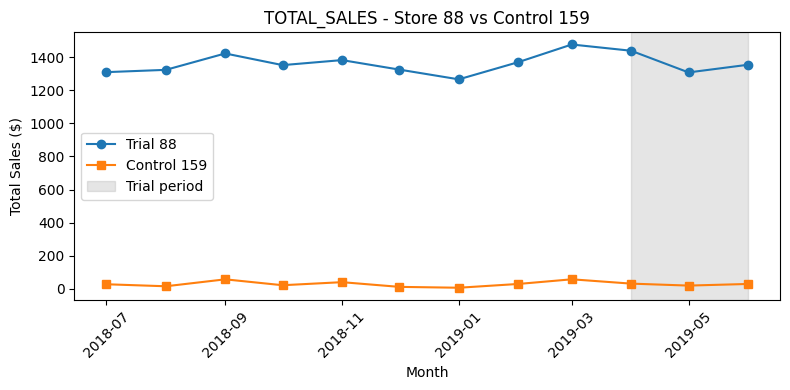

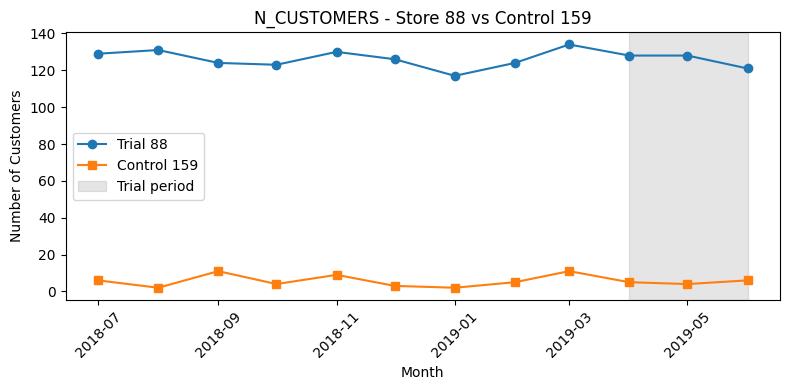

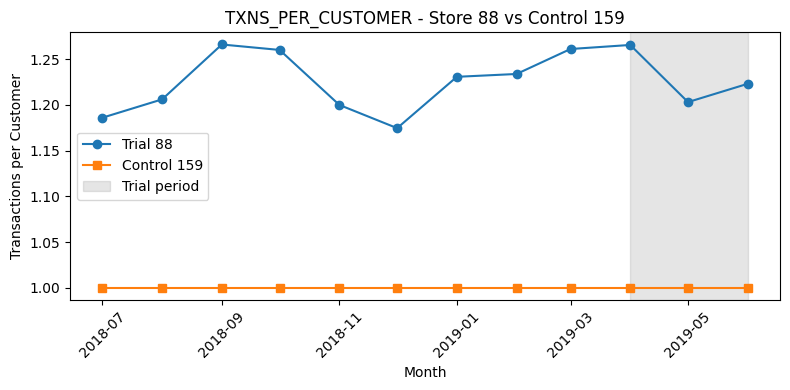

In [ ]:
# 7. Run plots for each trial store
for t in trial_stores:
    ctrl, corr = find_control(t)
    print(f"\nTrial store {t} -> Control store {ctrl} (corr={corr:.2f})")

    # 1. Sales plot
    plot_trial_vs_control(t, ctrl, 'TOTAL_SALES', "Total Sales ($)")

    # 2. Customers plot
    plot_trial_vs_control(t, ctrl, 'N_CUSTOMERS', "Number of Customers")

    # 3. Transactions per customer plot
    plot_trial_vs_control(t, ctrl, 'TXNS_PER_CUSTOMER', "Transactions per Customer")
